In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import time
from scipy.ndimage import convolve, generate_binary_structure

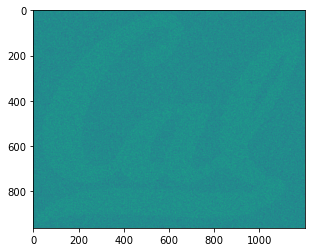

In [2]:
X = np.load("X.pkl", allow_pickle = True)

n = len(X[:, 0])
m = len(X[0])

plt.imshow(X)


Time to run one iteration of Gibbs Sampling:  8.697582006454468  seconds
Prediction for the time to calculate Z^100 would be:  869.7582006454468  seconds


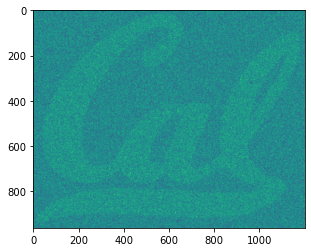

In [3]:

# Simple Gibbs Sampler

def Gibbs_Sampler(X, a, b, row, T):
    z0 = X # initial sample of Z^0
    n = len(X[:, 0]) # number of rows
    m = len(X[0]) # number of columns
    #print(n)
    #print(m)
    for t in np.arange(T):
        for i in np.arange(n):
            #print(i)
            for j in np.arange(m):
                #S = 0 # summation of neighborhood
                #if i == 961:
                #    print('test')
                if i == 0 and j == 0 : # top left corner
                    S = z0[i + 1, j] + z0[i, j + 1]

                elif i == 0 and j == m - 1: # top right corner
                    S = z0[i + 1, j] + z0[i, j - 1]

                elif i == n - 1 and j == 0 : # bottom left corner
                    S = z0[i - 1, j] + z0[i, j + 1]

                elif i == n - 1 and j ==  m - 1: # bottom right corner
                    S = z0[i - 1, j] + z0[i, j - 1]

                elif i == 0: # top row
                    S = z0[i + 1, j] + z0[i, j - 1] + z0[i, j + 1]

                elif j == 0: # left column
                    S = z0[i + 1, j] + z0[i - 1, j] + z0[i, j + 1]

                elif i == n - 1: # bottom row
                    S = z0[i, j - 1] + z0[i, j + 1] + z0[i - 1, j]

                elif j == m - 1: # right column
                    S = z0[i + 1, j] + z0[i - 1, j] + z0[i, j - 1]

                else: # anything in the center
                    S = z0[i - 1, j] + z0[i + 1, j] + z0[i, j - 1] + z0[i, j + 1]
                #if i == 961:
                #    print('test')
                mu = (row*X[i,j] + b*S)/(a + row)
                sigma = 1/(a+row)
                sample = np.random.normal(mu, sigma)
                #if i == 961:
                #    print('test')
                z0[i,j] = sample
    return z0
start = time.time()
Z = Gibbs_Sampler(X, 250, 62.5, .01,1) 
end = time.time()
function_time = end - start
plt.imshow(Z);
print("Time to run one iteration of Gibbs Sampling: ", function_time, " seconds")
print("Prediction for the time to calculate Z^100 would be: ", 100*function_time, " seconds")

Gibbs Blocked Sampler took:  145.3235034942627  seconds


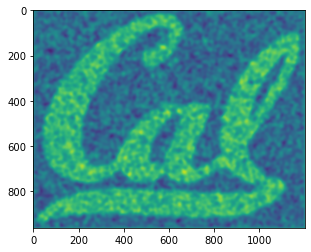

In [6]:
X = np.load("X.pkl", allow_pickle = True)

# Advance Gibbs Sampler - utilizes blocked Gibbs-Sampling

def Gibbs_Sampler_EO(X, a, b, row, T):
    
    # lambda functions to define even and odd structure of our matrix
    
    even = lambda i,j: 1 if (i+j)%2 == 0 else 0
    odd = lambda i,j: 0 if (i+j)%2 == 0 else 1
    z0 = X.copy() # initial sample of Z^0
    n = len(X[:, 0]) # number of rows
    m = len(X[0]) # number of columns
    
    for t in np.arange(T):
        print(t)
        delta = np.random.normal(0,1/(a+row),(n,m))
        
        
        # Solve for S
        
        z_pad = np.pad(z0, 1) # pad Z
        k = generate_binary_structure(2,1) # Binary Structure for neighbors
        S = convolve(z_pad,k, mode = 'constant', cval = 0) # find summation of neighbors, includes orignal point
        S = S[1:-1, 1:-1] # remove padding
        S = S - z0 # removes original point from neighborhood sum
        
        
        # Evens
        
        even_structure = np.array([even(i,j) for i in np.arange(n) for j in np.arange(m)]).reshape((n,m)) # even structure
        
        S_even = S*even_structure # even summation points
        
        X_even = X*even_structure # even X points
        
        delta_even = delta*even_structure # even delta Points
        z0_even = (row/(row+a))*X_even + (b/(b+row))*S_even + delta_even
        
        
        # Odds
        
        odd_structure = np.array([odd(i,j) for i in np.arange(n) for j in np.arange(m)]).reshape((n,m))
        S_odd = S*odd_structure
        X_odd = X*odd_structure
        delta_odd = delta*odd_structure
        z0_odd = (row/(row+a))*X_odd + (b/(b+row))*S_odd + delta_odd
        
        # combine odd and even
        
        z0 = z0_odd + z0_even
        
    return z0
start = time.time()
Z = Gibbs_Sampler_EO(X, 250, 62.5, .01,100) 
end = time.time()
print("Gibbs Blocked Sampler took: ", end - start, " seconds")
plt.imshow(Z);